In [16]:
import cobra
from cobra.io import load_model
import matplotlib.pyplot as plt

# load the textbook model
model = load_model("textbook")

In [21]:
def perform_dfba(model, initial_conditions, kinetic_params, time_points, biomass_reaction, substrate_update_reactions, dt):
    """
    Perform dynamic FBA (dFBA) simulation.
    ...
    """
    results = {key: [value] for key, value in initial_conditions.items()}

    # Correctly initialize results dictionary for time points
    for key in results:
        for _ in range(1, len(time_points)):
            results[key].append(0)  # Pre-fill with 0 to match the length of time_points

    for t_i in range(1, len(time_points)):
        for substrate, reaction_id in substrate_update_reactions.items():
            Km, Vmax = kinetic_params[substrate]
            substrate_concentration = results[substrate][t_i-1]
            uptake_rate = Vmax * substrate_concentration / (Km + substrate_concentration)
            model.reactions.get_by_id(reaction_id).lower_bound = -uptake_rate

        solution = model.optimize()
        if solution.status == 'optimal':
            biomass_growth_rate = solution.fluxes[biomass_reaction]
            results['biomass'][t_i] = results['biomass'][t_i-1] + biomass_growth_rate * results['biomass'][t_i-1] * dt

            for substrate, reaction_id in substrate_update_reactions.items():
                flux = solution.fluxes[reaction_id]
                results[substrate][t_i] = max(results[substrate][t_i-1] + flux * results['biomass'][t_i-1] * dt, 0)
        else:
            for key in results.keys():
                results[key][t_i] = results[key][t_i-1]

    return results



def plot_dfba_results(time_points, dfba_results, title='dFBA Simulation Results'):
    """
    Plot the results of a dFBA simulation.

    Parameters:
    - time_points (list): A list of time points at which the simulation was evaluated.
    - dfba_results (dict): A dictionary containing time series data for biomass and external metabolites.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    for key, values in dfba_results.items():
        plt.plot(time_points, values, label=key.capitalize())
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()



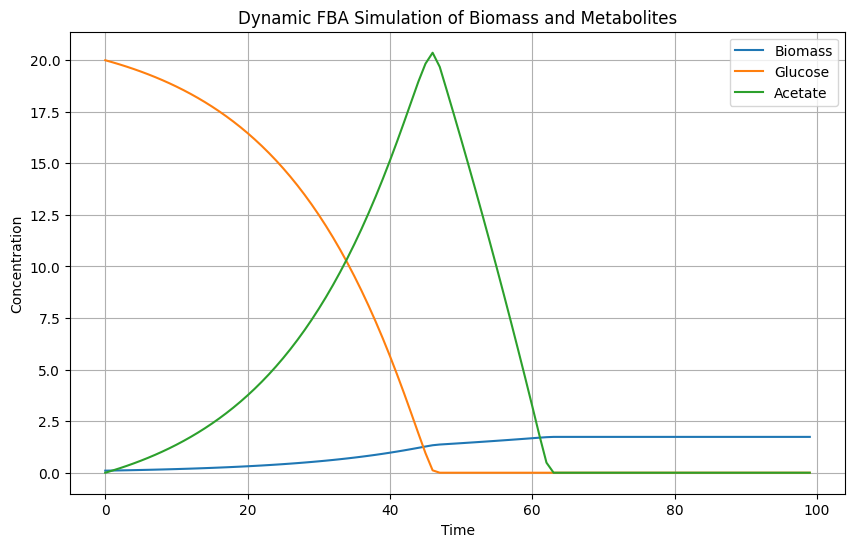

In [23]:
model.reactions.EX_o2_e.lower_bound = -2  # Limiting oxygen uptake
model.reactions.ATPM.lower_bound = 1     # Setting lower bound for ATP maintenance
model.reactions.ATPM.upper_bound = 1     # Setting upper bound for ATP maintenance

# Define initial conditions, kinetic parameters, and other necessary inputs
initial_conditions = {
    'biomass': 0.1,  # Initial biomass concentration
    'glucose': 20.0, # Initial glucose concentration
    'acetate': 0.0   # Initial acetate concentration
}

kinetic_params = {
    'glucose': (0.5, 2), # Km and Vmax for glucose
    'acetate': (0.5, 2)  # Km and Vmax for acetate
}

time_points = list(range(0, t_n))  # Simulation time points, matching your setup
substrate_update_reactions = {
    'glucose': 'EX_glc__D_e',  # Exchange reaction ID for glucose
    'acetate': 'EX_ac_e'       # Exchange reaction ID for acetate
}

dt = 0.5  # Time step, matching your setup

# Make sure to adjust the perform_dfba function if needed to initialize result arrays with sufficient size
dfba_results = perform_dfba(model, initial_conditions, kinetic_params, time_points, 
                            'Biomass_Ecoli_core', substrate_update_reactions, dt)

# visualize
plot_dfba_results(time_points, dfba_results, title='Dynamic FBA Simulation of Biomass and Metabolites')

In [10]:
# My super-simple dFBA
t_n = 100 # number of time points
dt=0.5 # Time interval

# Michaelis-Menten parameters for uptake
KM=0.5
Vmax=2

t_vec = list(range(0,t_n))
DFBA_biomass = [0] * t_n # initialize vector of glucose amounts
DFBA_GLC = [0] * t_n # initialize vector of glucose amounts
DFBA_ACE = [0] * t_n # initialize vector of acetate amounts

DFBA_biomass[0]=0.1 # Initial amount of biomass
DFBA_GLC[0]=20.0 # Initial amount of glucose
DFBA_ACE[0]=0.0 # Initial amount of acetate

# We limit O2, so the cell will secrete acetate
model.reactions.EX_o2_e.lower_bound=-2
# We lower the maintenance flux so acetate is not all lost in meintenance
model.reactions.ATPM.lower_bound=1
model.reactions.ATPM.upper_bound=1


# Start loop on time intervals ------------------------------------------------
for t_i in t_vec[1:]:
  # Compute glucose uptake rate using Michaelis-Menten
  DFBA_GLC_uptake = Vmax * DFBA_GLC[t_i-1]/(KM + DFBA_GLC[t_i-1])
  DFBA_ACE_uptake = Vmax * DFBA_ACE[t_i-1]/(KM + DFBA_ACE[t_i-1])

  # Impose Michaelis-Menten rate as maximal uptake rate for extracellular metabolites
  model.reactions.EX_glc__D_e.lower_bound = - DFBA_GLC_uptake
  model.reactions.EX_ac_e.lower_bound = - DFBA_ACE_uptake

  # Compute standard FBA solution (and check if feasible)
  solution = model.optimize()
  if(solution.status=='optimal'):
    vgrowth = solution.fluxes.Biomass_Ecoli_core
    v_GLC = solution.fluxes.EX_glc__D_e
    v_ACE = solution.fluxes.EX_ac_e
  else:
    vgrowth=0
    v_GLC=0
    v_ACE=0

  # Update Biomass amount
  DFBA_biomass[t_i]=DFBA_biomass[t_i-1] + vgrowth*DFBA_biomass[t_i-1]*dt

  # Update glucose amount
  DFBA_GLC[t_i]=DFBA_GLC[t_i-1] + v_GLC*DFBA_biomass[t_i-1]*dt
  if(DFBA_GLC[t_i]<0):
    DFBA_GLC[t_i]=0

  # Update acetate amount
  DFBA_ACE[t_i]=DFBA_ACE[t_i-1] + v_ACE*DFBA_biomass[t_i-1]*dt
  if(DFBA_ACE[t_i]<0):
    DFBA_ACE[t_i]=0

# End loop on time intervals ------------------------------------------------


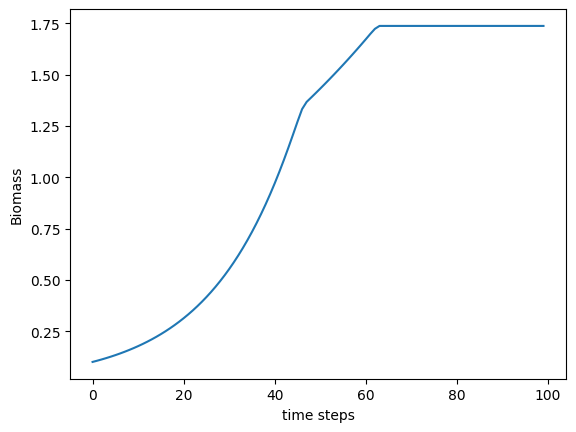

Text(0, 0.5, 'Extracellular Acetate')

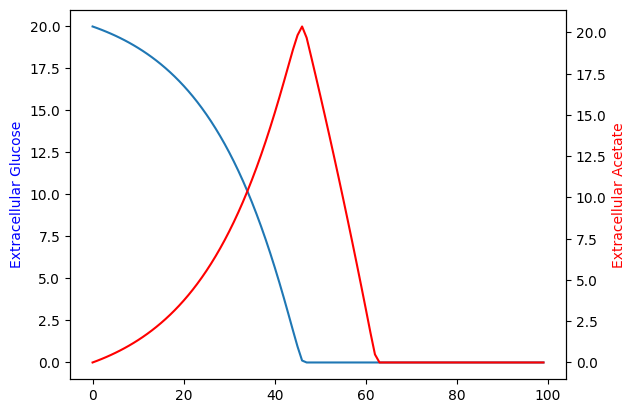

In [11]:
# plot results
plt.plot(t_vec,(DFBA_biomass))
plt.xlabel('time steps')
plt.ylabel('Biomass')
plt.show()

ax = plt.subplot(111)
ax.plot(t_vec,DFBA_GLC)
ax2 = plt.twinx(ax)
ax2.plot(t_vec,DFBA_ACE, color='r')

ax.set_ylabel('Extracellular Glucose', color='b')
ax2.set_ylabel('Extracellular Acetate', color='r')